## Run the program and collect outputs

In [11]:
!g++ --version

Configured with: --prefix=/Library/Developer/CommandLineTools/usr --with-gxx-include-dir=/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/4.2.1
Apple clang version 11.0.0 (clang-1100.0.33.8)
Target: x86_64-apple-darwin19.0.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


In [12]:
!make

make: `main' is up to date.


In [13]:
output = !./main

In [14]:
xys = [tuple(l.split()) for l in output ]
xs = [float(x) for x, _ in xys]
ys = [float(y) for _, y in xys]

## Plot time spent for different sizes of input

In [20]:
import matplotlib.pyplot as plt

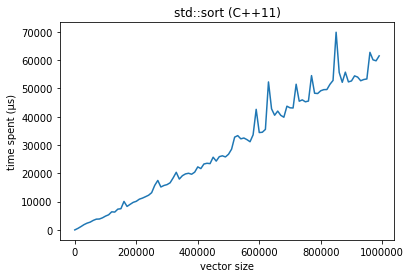

In [21]:
plt.title("std::sort (C++11)")
plt.xlabel("vector size")
plt.ylabel("time spent (μs)")
plt.plot(xs, ys)